# IFN712 Research in IT Practice

# Tweet filtering based on user interests using doc2vec & unsupervised clustering

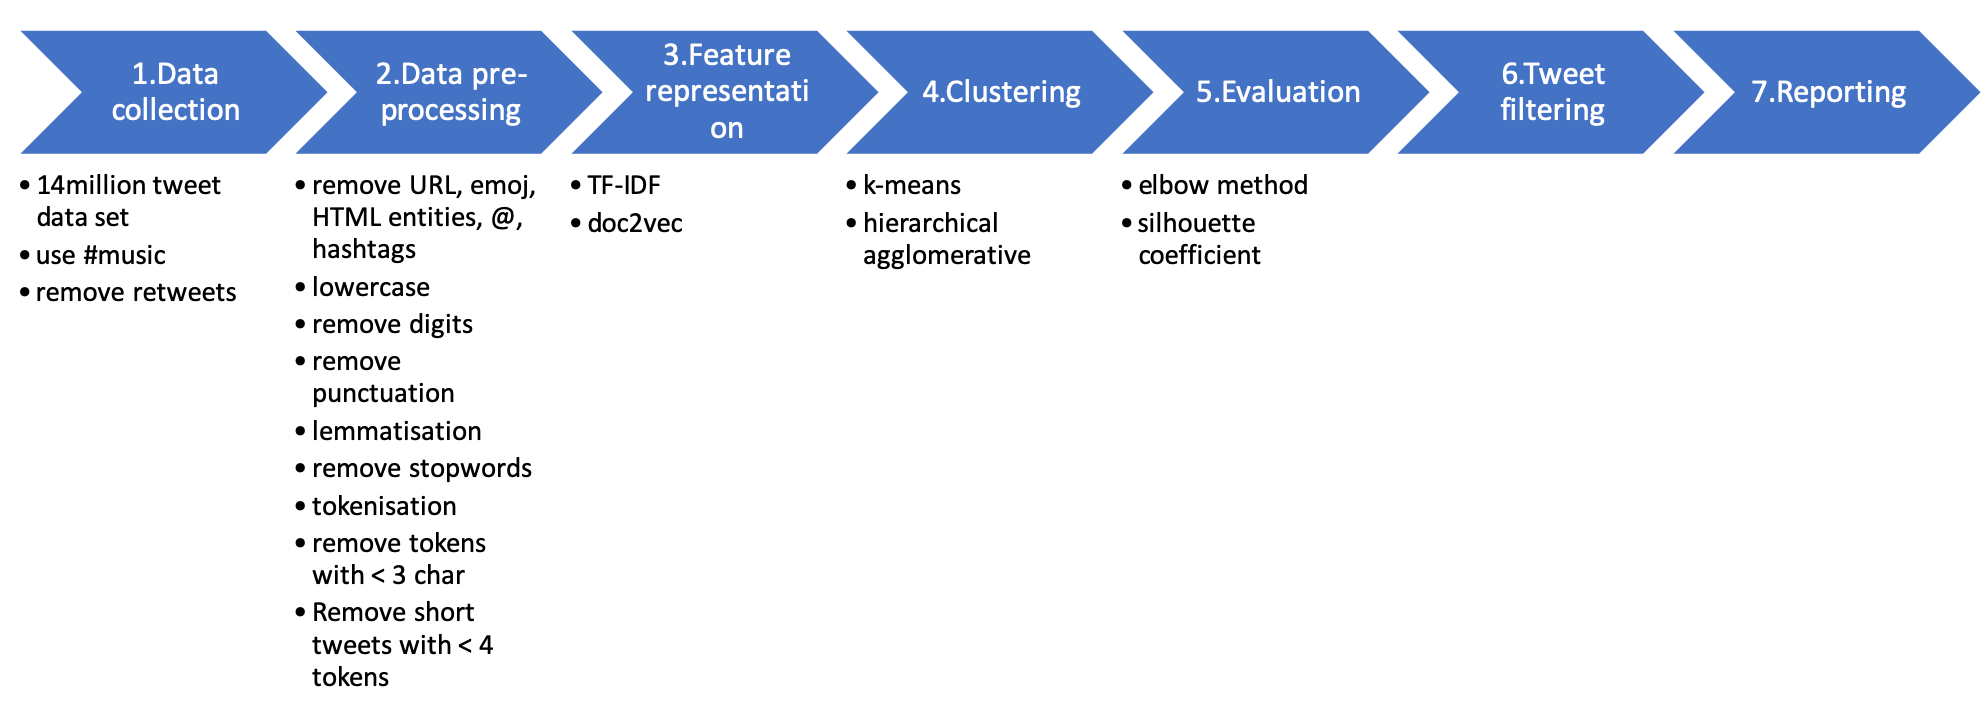

# 1. Data Collection

SQL Queries<br>
select id,text from Tweets where user = any (select distinct user from Tweets where hashtags_c like '%music%') INTO OUTFILE 'tweets_v4.txt' fields terminated by '\t' enclosed by '"' escaped by '"' lines terminated by '\r\n';

select id, user, created_at, favorite_count, retweet_count from Tweets where user = any (select distinct user from Tweets where hashtags_c like '%music%') INTO OUTFILE 'tweets_otherinfo.txt' fields terminated by '\t' enclosed by '"' escaped by '"' lines terminated by '\r\n';

In [1]:
# import python libraries
import pandas as pd
import numpy as np

In [2]:
#read a text file containing tweet ID and Tweet
df = pd.read_csv('tweets_v5.txt', sep="\t",quotechar='"', header=None)

In [3]:
# change column names
df.columns = ['Tweet ID', 'Tweet']

In [4]:
#read a text file containing Tweet ID", User, Created At, Favorite Count, "Retweet Count
df_info = pd.read_csv('tweets_otherinfo.txt', sep="\t",quotechar='"', header=None)

In [5]:
# change column names
df_info.columns = ["Tweet ID", "User", "Created At", "Favorite Count", "Retweet Count"]

In [6]:
pd.set_option('display.max_colwidth', -1)

/Users/ShinnoOh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


#### Change data types

In [7]:
df["Tweet ID"] = df["Tweet ID"].astype("str", copy=True, errors='raise')
df["Tweet"] = df["Tweet"].astype("str", copy=True, errors='raise')
df_info["Tweet ID"] = df_info["Tweet ID"].astype("str", copy=True, errors='raise')
df_info["User"] = df_info["User"].astype("str", copy=True, errors='raise')
df_info["Created At"] = df_info["Created At"].astype("str", copy=True, errors='raise')
df_info["Favorite Count"] = df_info["Favorite Count"].astype("int32", copy=True, errors='raise')
df_info["Retweet Count"] = df_info["Retweet Count"].astype("int32", copy=True, errors='raise')

df has different number of columns (7578) than df_info (7571)
check where it comes from and correct it

In [8]:
df.shape

(7578, 2)

In [9]:
df_info.shape

(7571, 5)

In [10]:
# find the unmatching column in df datafarame
for i in range (0, 7571):
    if df_info["Tweet ID"][i] != df["Tweet ID"][i]:
        print(i)
        break

2926


In [11]:
df.at[2925,"Tweet"] ="#hotelcalifornia  #tyga #music #baileys"

In [12]:
df.drop([df.index[2926], df.index[2927], df.index[2928]], inplace=True)

In [13]:
df= df.reset_index(drop=True)

In [14]:
# find the unmatching column in df datafarame
for i in range (0, 7571):
    if df_info["Tweet ID"][i] != df["Tweet ID"][i]:
        print(i)
        break

5115


In [15]:
df.at[5114,"Tweet"]  = "Best #UKG #progressive #housemusic #Dubstep is on #live on @PureEDMRadio with @JRFOVERS #EDM #rt #follow http://t.co/I1jO6w0GlC"

In [16]:
df.drop([df.index[5115],df.index[5116]], inplace=True)

In [17]:
df= df.reset_index(drop=True)

In [18]:
# find the unmatching column in df datafarame
for i in range (0, 7571):
    if df_info["Tweet ID"][i] != df["Tweet ID"][i]:
        print(i)
        break

5170


In [19]:
df.at[5169,"Tweet"]  = "RT @SimonaEssargii: Best #UKG #progressive #housemusic #Dubstep is on #live on @PureEDMRadio with @JRFOVERS #EDM #rt #follow http://t.co/…"

In [20]:
df.drop([df.index[5170],df.index[5171]], inplace=True)
df= df.reset_index(drop=True)

In [21]:
df.shape

(7571, 2)

## Remove Retweets

In [22]:
#Remove retweets
df = df[~df["Tweet"].str.startswith('RT')]

In [23]:
df= df.reset_index(drop=True)
df.shape

(5732, 2)

In [24]:
df_test_user=  df.merge(df_info[["Tweet ID", "User"]], how='left', on="Tweet ID")

In [25]:
df_test_user["User"].value_counts()

27260086     90
599012640    74
362977517    59
327844075    52
237507695    48
             ..
43259852     1 
44436448     1 
20596793     1 
76005590     1 
99463615     1 
Name: User, Length: 2419, dtype: int64

# 2. Data Preprocessing

1. remove URL, Reserved words(RT, FAV), Emoji
2. lowercase the text
3. remove digits
4. unescape HTML entities
5. remove single characters
6. remove punctuation
7. lemmatisation
8. remove stopwords
9. tokenisation
10. Remove short tweets with =<3 tokens

In [26]:
#installing tweet-preprocessor
#!pip install tweet-preprocessor
#!pip install html

In [27]:
#important libraries for data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import string 
import preprocessor as p
import re
import html

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ShinnoOh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ShinnoOh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
#function to remove URL, Reserved words(RT, FAV), Emoji
def tweet_processing(text):
    #set options for removal
    p.set_options(p.OPT.URL,p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.HASHTAG, p.OPT.MENTION) 
    return p.clean(text)

In [29]:
#function to lowercase the text to reduce the size of the vocabulary of our text data
def text_lowercase(text): 
    return text.lower() 

In [30]:
#function to remove digits
def remove_numbers(text): 
    result = re.sub(r'\d+', '', text) 
    return result 

In [31]:
#function to unescape HTML entities
def unescape_html(text):
    return html.unescape(text)

In [32]:
#function to remove single characters
def remove_single_char(text):
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)     
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

In [33]:
# function to remove punctuation
#!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def remove_punctuation(text):   
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 
    return text.translate(translator)

In [34]:
#function to lemmatise tweets
def lemmatiser(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmatised_text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])
    return lemmatised_text

In [35]:
#function to remove stopwords and tokenise tweets
def tokenisation_remove_stopword(text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence2 = [w for w in filtered_sentence if len(w)>2]
    return filtered_sentence2

In [36]:
#perform data preprocessing
df_tokenised = pd.DataFrame(columns=["Tweet ID", "Tweet Tokenised"])

for i, text in enumerate(df["Tweet"]):
        text_processed = tweet_processing(text)
        text_processed =  text_lowercase(text_processed)
        text_processed =  remove_numbers(text_processed)
        text_processed = unescape_html(text_processed)
        text_processed = remove_single_char(text_processed)
        text_processed = lemmatiser(text_processed)
        text_processed =  remove_punctuation(text_processed)       
        df.loc[i,"Tweet_Cleaned"] = text_processed
        filtered_sentence = tokenisation_remove_stopword(text_processed)
        df_tokenised = df_tokenised.append({"Tweet ID": df["Tweet ID"][i], "Tweet Tokenised": filtered_sentence}, ignore_index=True)

In [37]:
df_tokenised["Tweet Tokenised"].head(20)

0     [check, single, one, time, myspace, spread, word, thanks]                                                                 
1     [chillin, myspace, music, check, live]                                                                                    
2     [single, one, time, hit, itunes, july, spread, word, request, local, radio, station, come, visit]                         
3     [columbus, red, white, boom, fri, come, full, support, five, best, wnci, justin, bieber, poster, get, picked, meet, greet]
4     [one, time, itunes, right, buy, time, let, make, lol, amazing, small, town, thank, much]                                  
5     [fan, friend, family, amazing, thanks, love]                                                                              
6     [congrats, single, sound]                                                                                                 
7     [holy, crap, trending, topic, twitter, shock, right, thank, much, grateful, support]       

In [38]:
#remove tweets with tokens less than or equal to 3
df_preprocessed= df_tokenised[df_tokenised["Tweet Tokenised"].str.len()>3]
df_preprocessed= df_preprocessed.reset_index(drop=True)

 ### Statistics about the corpus after preprocessing
Number of Tweets: 3974 <br>
Number of Users: 2920<br>
Average Number of Tokens in Tweets: 7.1<br>
Median Value: 7<br>
Standard Deviation: 2.54<br>

In [39]:
#number of tweets
df_preprocessed.shape

(3974, 2)

In [40]:
#concatenate df & df_info
df_preprocessed_user=  df_preprocessed.merge(df_info[["Tweet ID", "User"]], how='left', on="Tweet ID")

In [41]:
# number of users
df_preprocessed_user["User"].value_counts()

27260086     73
599012640    67
126293935    47
725522406    38
362977517    36
             ..
413857314    1 
582780806    1 
310155121    1 
280639251    1 
570543332    1 
Name: User, Length: 1799, dtype: int64

In [42]:
df_preprocessed["# of Tokens"] = np.nan
for i in range(df_preprocessed["Tweet Tokenised"].__len__()):
    df_preprocessed["# of Tokens"].iloc[i] = df_preprocessed["Tweet Tokenised"].iloc[i].__len__() 

/Users/ShinnoOh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
# average number of tokens in tweets
df_preprocessed["# of Tokens"].sum() /df_preprocessed["# of Tokens"].count()

7.106441872169099

In [44]:
# standard deviation of tokens in tweets
df_preprocessed["# of Tokens"].median()

7.0

In [45]:
# median value of tokens in tweets
df_preprocessed["# of Tokens"].std()

2.5415735372647132

# 3. Feature Representation

##  1. TF-IDF

In [46]:
df_tfidf = df_preprocessed_user.copy()

In [47]:
tokenised_matrix = []
for i, text_list in enumerate(df_tfidf["Tweet Tokenised"]):
    tokenised_matrix.append(text_list)
print(tokenised_matrix[0])

['check', 'single', 'one', 'time', 'myspace', 'spread', 'word', 'thanks']


In [48]:
#perform tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer  

def dummy_fun(doc):
    return doc

#vectoriser = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, max_features=1000)  
#vectoriser = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, max_features=1000, min_df=10)
vectoriser = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, max_features=1000, min_df=20)
#vectoriser = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, max_features=1000, min_df=50)
#vectoriser = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, max_features=1000, min_df=100) 
#vectoriser = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, max_features=1000, min_df=100, max_df=0.5) 
#vectoriser = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, max_features=1000, min_df=100, max_df=0.1) 
#print(tokenised_matrix)
tfidf = vectoriser.fit_transform(tokenised_matrix)
tfidf_array = tfidf.toarray()

In [49]:
# frequent words list
#df_min = 50, count = 180
#min_df=100, count = 73
#min_df=100, max_df=0.1, count = 70
tfidf_vovab = vectoriser.get_feature_names()
print("The words remaining for TF-IDF feature representation")
print(tfidf_vovab)
print("The number of words remaininig: " + str(len(tfidf_vovab)))

The words remaining for TF-IDF feature representation
['album', 'also', 'always', 'amazing', 'another', 'artist', 'away', 'awesome', 'baby', 'back', 'band', 'beat', 'best', 'big', 'black', 'bless', 'blog', 'blue', 'book', 'boy', 'brand', 'brown', 'buy', 'call', 'chance', 'check', 'chris', 'city', 'click', 'clothing', 'com', 'come', 'coming', 'could', 'cover', 'day', 'dead', 'dis', 'diva', 'doe', 'done', 'download', 'dream', 'ever', 'every', 'everyone', 'everything', 'excited', 'eye', 'family', 'fan', 'favorite', 'feat', 'feel', 'find', 'first', 'follow', 'follower', 'free', 'freestyle', 'friday', 'friend', 'full', 'funk', 'get', 'girl', 'give', 'going', 'gon', 'good', 'got', 'great', 'guy', 'hanging', 'happy', 'hard', 'hear', 'heard', 'help', 'high', 'hip', 'hit', 'hop', 'hot', 'house', 'interview', 'istanbul', 'itunes', 'jeramiah', 'job', 'join', 'justin', 'keep', 'kelly', 'khaos', 'know', 'kris', 'kross', 'last', 'let', 'life', 'like', 'link', 'listen', 'listening', 'live', 'long', '

In [50]:
#vector for the first tweet
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
print(tfidf_array[:20])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.38 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.579 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0.404 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0.312 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.336 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0.433 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0.415 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0.364 0 0 0 0 0 0.317 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 

## 2. doc2vec

In [51]:
#!pip install gensim

In [52]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tweets_doc2vec = [TaggedDocument(data, [i]) for i, data in enumerate(tokenised_matrix)]

#model: Distributed Bag of Words, dimention: 100, window_size: 5, minimum word count: 1
doc_model = Doc2Vec(documents= tweets_doc2vec, dm = 0, vector_size=100, window=5, min_count=2, epochs=15)
#epoch: 25
doc_model.train(tweets_doc2vec, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)
doc_vectors = doc_model.docvecs.vectors_docs

In [53]:
doc_model.docvecs[0]

array([0.00867, 0.00665, 0.0435, 0.0435, 0.0341, -0.0532, 0.0387, 0.00274, 0.0126, -0.0343, -0.0432, 0.0655, -0.0458, -0.0589, -0.001, 0.0107, 0.00158, 0.0366, -0.0257, 0.0555, -0.0125, -0.000305, 0.00681, 0.0402, 0.00342, -0.0126, -0.00283, 0.0553, -0.0262, -0.0562, -0.0383, -0.0836, 0.0459, -0.0209, -0.017, -0.00414, 0.0295, -0.0456, 0.0131, 0.0225, -0.00681, -0.065, -0.035, 0.0164, 0.0744, -0.0689, 0.00655, -0.0367, 0.00276, -0.0881, -0.0471, -0.000206, 0.0316, 0.0226, 0.00848, 0.0152, 0.0141, -0.0701, 0.0552, -0.0295, -0.00502, 0.0518, -0.013, 0.00457, -0.0479, 0.112, 0.0462, -0.11, -0.0186, -0.0345, -0.0679, -0.0391, -0.0106, -0.0314, -0.00587, 0.0916, 0.0609, -0.0424, -0.0206, 0.112, -0.0163, 0.0258, 0.0732, -0.0125, 0.0418, -0.00172, 0.00209, -0.0526, 0.0119, 0.049, 0.118, -0.0441, 0.0103, -0.0187, -0.0488, 0.0252, -0.00868, -0.0583, -0.0413, -0.0834], dtype=float32)

In [54]:
d2v_vocab = doc_model.wv.vocab

# 4. Clustering

## 1. K-means Clustering

### 1-1. TF-IDF

In [55]:
#import libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [56]:
#function to get elbow score
def elbow_method(vector, min_k, max_k, step):
    iters = range(min_k,max_k+1, step)
    rs = 10
    clusters = []
    score = []
    clusters = [KMeans(n_clusters=k, random_state=rs, n_jobs=10).fit(vector) for k in iters]               
    score = [clusters[i].inertia_ for i in range(len(clusters))] 
    x= [clusters[i].n_clusters for i in range(len(clusters))]
    plt.plot(x, score, marker='*')
    plt.xticks([clusters[i].n_clusters for i in range(len(clusters))])
    plt.grid(False)
    plt.xlabel('k')
    plt.ylabel('Within-Cluster Variance')
    plt.title('Elbow Method')
    plt.show()
    return clusters

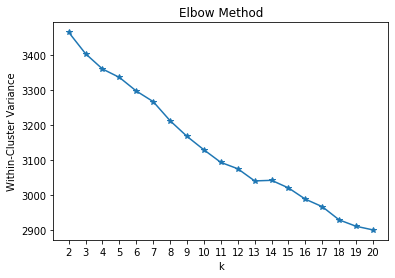

In [57]:
#elbow score for TF-IDF and K-means
cluster_tfidf = elbow_method(tfidf, 2, 20 , 1)

It is difficult to identify the elbow, which is the optimal number of k (=clusters) from this plot

In [58]:
#!pip install yellowbrick

In [59]:
#function to get optimal number of clusters
from yellowbrick.cluster import KElbowVisualizer
def get_optimal_kmeans (vector, min_k, max_k):
    rs=10
    clusters = KMeans(random_state=rs, n_jobs=10)
    visualizer = KElbowVisualizer(clusters, metric="silhouette", k=(min_k,max_k+1), timings=True,locate_elbow=True)
    visualizer.fit(vector).elbow_value_
    visualizer.show() 

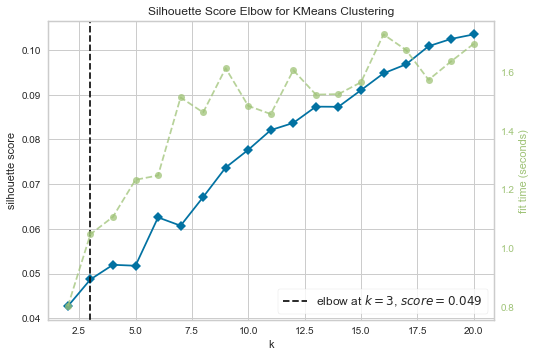

In [60]:
get_optimal_kmeans(tfidf, 2,20)

Optimal number of clusters for the combination of TF-IDF and K-means Clustering is 3

In [61]:
# function to visualizer silhouette distribution
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
def visualise_silhouette_score(vector, k, color):
    rs = 10
    model = KMeans(k, random_state=rs ,n_jobs=10)
    visualizer = SilhouetteVisualizer(model, colors=color)
    visualizer.fit(vector)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

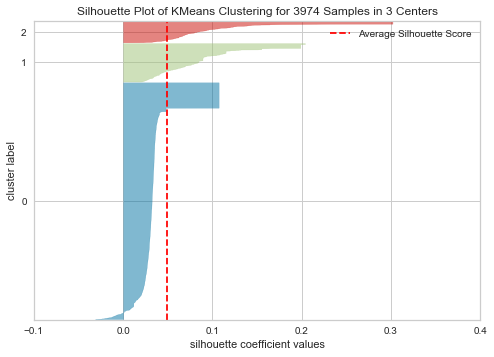

In [62]:
# get the silhouette distribution when k=3
visualise_silhouette_score(tfidf, 3,'yellowbrick')

Most of data points in Cluster 0 have silhouette score below the average, which implies that clusters are not well separated.

In [63]:
def find_silhouette_score (vector, k, k2, k3):
    for k in [k, k2, k3]:
        kmeans = KMeans(n_clusters=k, random_state=10, n_jobs=10).fit(vector)
        print("Silhouette score for k=", k, silhouette_score(vector, kmeans.predict(vector)))    

### 1-2. doc2vec 

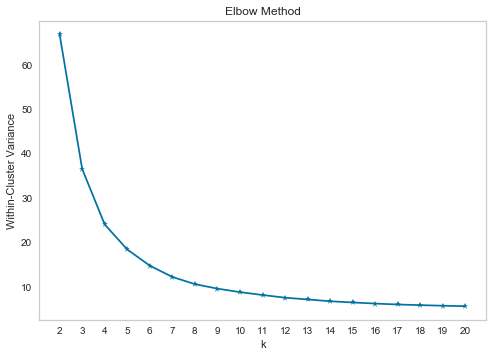

In [64]:
#elbow method
cluster2 = elbow_method(doc_vectors, 2, 20 , 1)

/Users/ShinnoOh/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/ShinnoOh/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/ShinnoOh/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


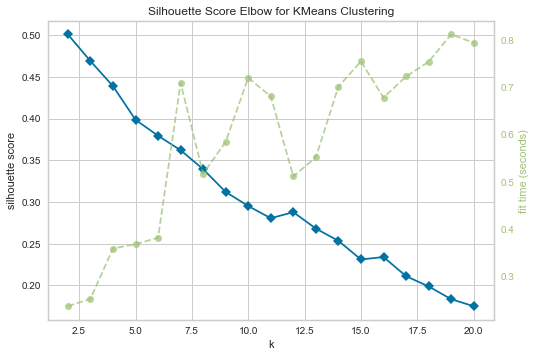

In [65]:
#identify the optimal number of clusters for doc2vec
get_optimal_kmeans (doc_vectors, 2, 20)

The optimal number of clusters for the combination of doc2vec and K-means Clustering is 8

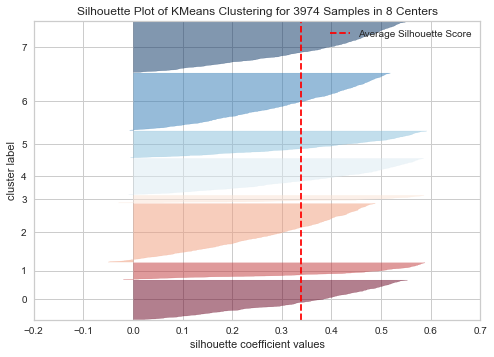

In [66]:
#get silhouette distribution
visualise_silhouette_score(doc_vectors, 8, 'RdBu')

Overall, the produced model has some good indicators of good clusters. <br>
Firstly, we can see that distribution of silhouette scores is very similar for each cluster and all clusters have silhouette score above the average.<br>
Also, the thickness of clusters is similar except for cluster 2 &4 which means the number of data points are evenly distributed.

In [67]:
cluster_d2v = KMeans(n_clusters=8, random_state=10, n_jobs=10).fit(doc_vectors)

In [68]:
from sklearn.decomposition import PCA
def get_pca_doc2vec(vector, cluster):
    X = cluster_d2v
    labels=cluster.labels_.tolist()
    pca = PCA(n_components=2).fit(vector)
    datapoint = pca.transform(vector)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure
    #label1 = [“#FFFF00”, “#008000”, “#0000FF”, “#800080”]
    label1 = ["#2a4d69","#4b86b4","#adcbe3","#e7eff6","#63ace5","#eee3e7","#eec9d2","#f6abb6"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    centroids = cluster.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker="^", s=150, c="#000000")
    plt.show()

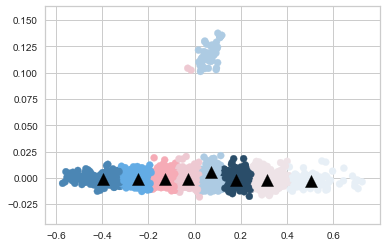

In [69]:
get_pca_doc2vec(doc_vectors, cluster_d2v)

Another visualisation of clusters using the PCA analysis. <br>
The figure shows the distribution of datapoints in reduced dimensions. <br>
We can see clusters are very close to each other which is not good but still datapoints are clusters together and not scattered.

## 2. Hierarchical Clustering 

### 2-1. TF-IDF

In [70]:
import scipy.cluster.hierarchy as hi
#function to create dendrogram
def dendrogram(dist, vector_name):
    Z = hi.linkage(dist, 'ward')
    fig, axes = plt.subplots(figsize=(30, 10))
    dn = hi.dendrogram(Z, ax=axes, leaf_rotation=90) #orientation='right'
    plt.title('Dendrogram for ' + vector_name)
    plt.ylabel('Distance')
    plt.xlabel('Tweet Index')
    plt.grid(False)
    plt.show()
    return dn

In [71]:
#caclulate cosine similarity matrix using TF-IDF matrix
#from sklearn.metrics.pairwise import cosine_similarity
#dist_tfidf = 1- cosine_similarity(tfidf)

In [72]:
#labels = df_preprocessed["Tweet ID"].astype(str).values.tolist()

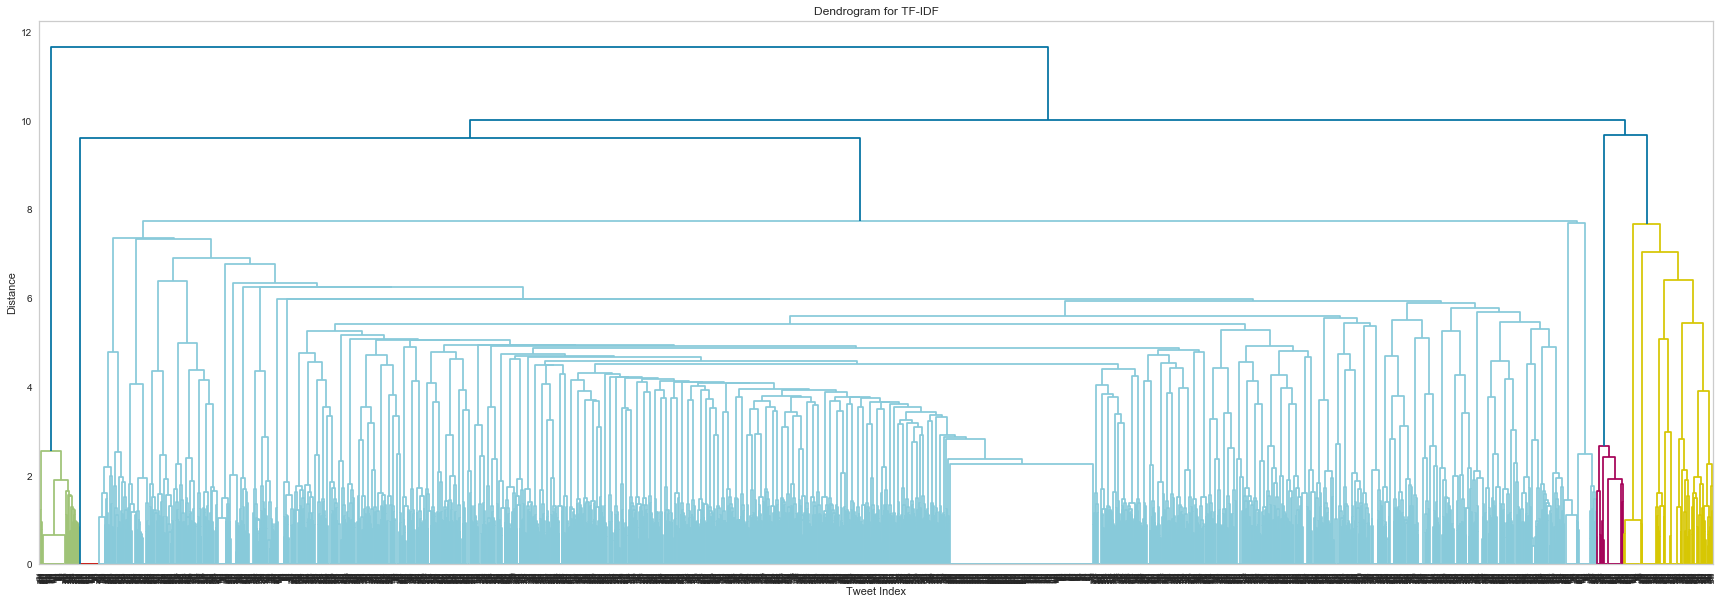

In [73]:
dn_tfidf = dendrogram(tfidf.toarray(), "TF-IDF")

The above dendrogram have too many hirarchies and difficult to see which tweets are grouped together. <br>
Therefore, in the next step, create a smaller dendrogram with the left botton nodes

In [74]:
#function to get 50 tweets from the left bottom of the above dendrogram
def get_bottom_node_index(dist, dn_model):
    new_labels = []
    new_dis = []
    new_tweets = dn_model['ivl'][0:50]
    for direction, index in enumerate(new_tweets):
        new_index = int(index)
        new_labels.append(new_index) 
        new_dis.append(dist[new_index])
    return new_dis, new_labels

In [75]:
new_dist_tfidf, new_labels_tfidf = get_bottom_node_index(tfidf.toarray(), dn_tfidf)

In [76]:
#function to create a smaller dendrogram
def dendrogram_small(dist, vector_name, labels):
    Z = hi.linkage(dist, 'ward')
    fig, axes = plt.subplots(figsize=(10, 5))
    dn = hi.dendrogram(Z, ax=axes, labels = labels)
    plt.title('Sample Dendrogram from Left Bottom Nodes for ' + vector_name)
    plt.ylabel('Distance')
    plt.xlabel('Tweet Index')
    plt.grid(False)
    plt.show()
    return dn

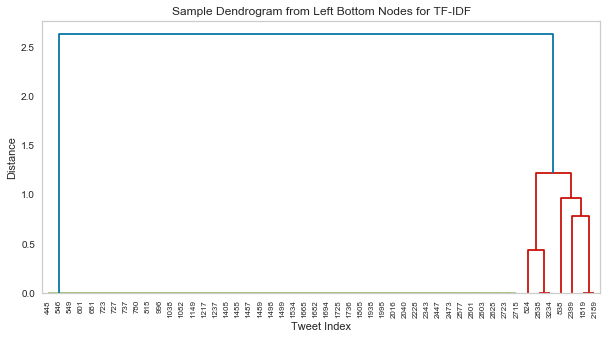

In [77]:
dn_tfidf_small = dendrogram_small(new_dist_tfidf, "TF-IDF", new_labels_tfidf)

In [82]:
#identify which tweets are in the clusters above
print("Green cluster: love song")
dn2_index_30 = dn_tfidf_small['ivl'][0:42]
for i, index in enumerate(dn2_index_30):
    print("Tweet ID: ",df_tokenised["Tweet ID"].iloc[index], tokenised_matrix[index])
print("Red Cluster: love music")
dn2_index_50 = dn_tfidf_small['ivl'][42:49]
for i, index in enumerate(dn2_index_50):
    print("Tweet ID: ",df_tokenised["Tweet ID"].iloc[index], tokenised_matrix[index])

Green cluster: love song
Tweet ID:  329856902316048384 ['posted', 'new', 'song', 'conversation']
Tweet ID:  329863642814226432 ['posted', 'new', 'song', 'fixing', 'blow', 'dola']
Tweet ID:  329863706181767168 ['posted', 'new', 'song', 'kidults']
Tweet ID:  329864657802244096 ['posted', 'new', 'song', 'wish', 'turned', 'soundz', 'rhythm']
Tweet ID:  329866889306202112 ['posted', 'new', 'song', 'pembuktian']
Tweet ID:  329872132240732160 ['posted', 'new', 'song', 'intro']
Tweet ID:  329872405696761856 ['posted', 'new', 'song', 'anniversary', 'produced', 'costello', 'enterprise']
Tweet ID:  329872597502267392 ['posted', 'new', 'song', 'imayborn']
Tweet ID:  329874042268041217 ['posted', 'new', 'song', 'darkness', 'rising', 'reboot', 'studio', 'edit']
Tweet ID:  329875048166998016 ['posted', 'new', 'song', 'jella']
Tweet ID:  329884682097410049 ['posted', 'new', 'song', 'memory', 'wing', 'dna']
Tweet ID:  329909979618365440 ['posted', 'new', 'song', 'comeon', 'dance', 'freebeat', 'instrume

It seems similar tweets are grouped together from the above samples.

In [83]:
#function to get the optimal number of clusters for TF-IDF and hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
def get_optimal_hierarchical (vector, min_k, max_k):
    clusters = AgglomerativeClustering(linkage='ward')
    visualizer = KElbowVisualizer(clusters, metric="silhouette", k=(min_k,max_k+1), timings=True,locate_elbow=False)
    visualizer.fit(vector).elbow_value_
    visualizer.show() 

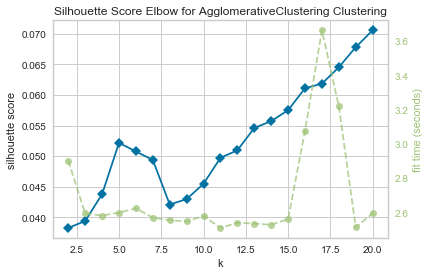

In [84]:
get_optimal_hierarchical (tfidf.toarray(), 2, 20)

Optimal number fo clusters for the combination of TF-IDF and Hierarchical Clustering is 5.

In [85]:
from sklearn.cluster import AgglomerativeClustering
def get_silhouette_score_hie(vector, k, k2, k3):
    for k in [k, k2, k3]:
        hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(vector)
        hierarchical_label = hierarchical.labels_
        print("Silhouette score for k=", k, silhouette_score(vector, hierarchical_label))

### 2-2. doc2vec

In [86]:
from sklearn.metrics.pairwise import cosine_similarity
dist_doc2vec = 1- cosine_similarity(doc_vectors)

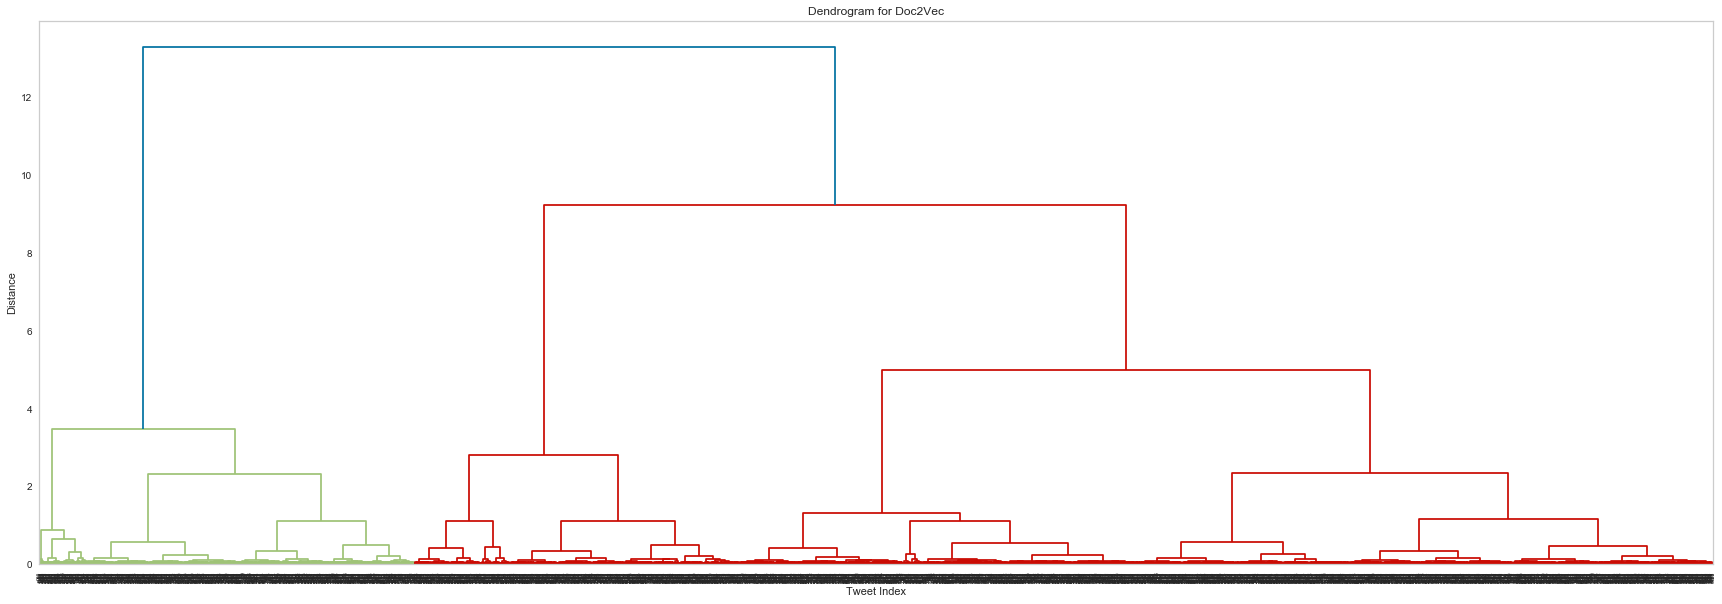

In [87]:
dn_doc2vec = dendrogram(doc_vectors, "Doc2Vec")

In [88]:
new_dist_doc2vec, new_labels_doc2vec = get_bottom_node_index(doc_vectors, dn_doc2vec)

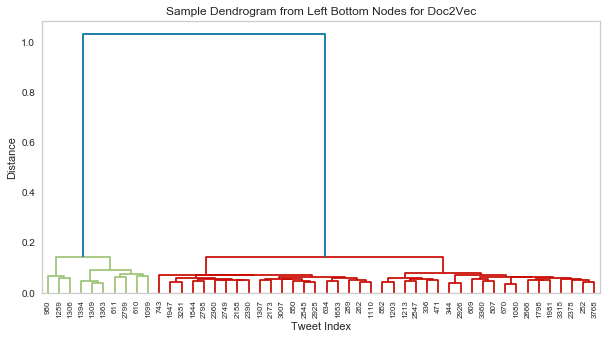

In [89]:
dn_doc2vec_small = dendrogram_small(new_dist_doc2vec, "Doc2Vec", new_labels_doc2vec)

In [90]:
print("Green cluster: ")
dn2_index_30 = dn_doc2vec_small['ivl'][0:18]
for i, index in enumerate(dn2_index_30):
    print("Tweet ID: ",df_tokenised["Tweet ID"].iloc[index], tokenised_matrix[index])
print("Red Cluster: ")
dn2_index_50 = dn_doc2vec_small['ivl'][19:49]
for i, index in enumerate(dn2_index_50):
    print("Tweet ID: ",df_tokenised["Tweet ID"].iloc[index], tokenised_matrix[index])

Green cluster: 
Tweet ID:  329884187148570626 ['favourite', 'version', 'sibongile', 'lord', 'lift', 'name', 'high', 'oweya', 'oweya', 'oweya', 'sibongile', 'tune', 'decates']
Tweet ID:  329932781616525313 ['rack', 'pocket', 'freebass', 'feat', 'streetking', 'icy', 'mike', 'supamario', 'roddiemack', 'releasing', 'freedwnld']
Tweet ID:  329938389656821762 ['list', 'kevin', 'hart', 'pooch', 'hall', 'evelyn', 'stevie', 'toya', 'somaya', 'reece']
Tweet ID:  329942344814194688 ['udah', 'submit', 'foto', 'keren', 'buat', 'terpilih', 'nonton', 'carly', 'call', 'maybe', 'tiket', 'konsernya', 'beat']
Tweet ID:  329938528031084545 ['udah', 'submit', 'foto', 'keren', 'buat', 'terpilih', 'nonton', 'carly', 'call', 'maybe', 'tiket', 'konsernya', 'beat']
Tweet ID:  329941271403696128 ['udah', 'submit', 'foto', 'keren', 'buat', 'terpilih', 'nonton', 'carly', 'call', 'maybe', 'tiket', 'konsernya', 'beat']
Tweet ID:  329865274994065408 ['damn', 'jus', 'hit', 'dog', 'bro', 'smh', 'dis', 'nigga', 'layin',

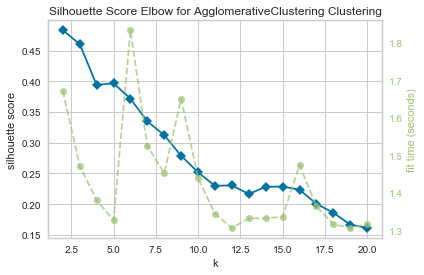

In [91]:
get_optimal_hierarchical (doc_vectors, 2, 20)

Optimal number fo clusters for the combination of doc2vec and Hierarchical Clustering is 3.

# Evaluation

## Summary of optimal number of clusters (k)

| Festure Representation Technique | Clustering Technique | Optimal Number of Clusters |
| :- | :- | -: |
| TF-IDF | K-means | 3 |
| TF-IDF | Agglomerative Hierarchical | 5 |
| Doc2Vec | K-means | 8 |
| Doc2Vec | Agglomerative Hierarchical | 3 |

## Find silhouette score for k=3, 5, 8

| k=3 | Festure Representation | Clustering | Silhouette Score | 
| --- | :- | :- | -: |
| 1 | TF-IDF | K-means | 0.0487 |
| 2 | TF-IDF | HAC | 0.0394 |
| 3 | Doc2Vec | K-means | 0.4692 |
| 4 | Doc2Vec | HAC | 0.4663 |

| k=8 | Festure Representation | Clustering | Silhouette Score | 
| --- | :- | :- | -: |
| 1 | TF-IDF | K-means | 0.0671 |
| 2 | TF-IDF | HAC | 0.0421 |
| 3 | Doc2Vec | K-means | 0.3403 |
| 4 | Doc2Vec | HAC | 0.3048 |

| k=5 | Festure Representation | Clustering | Silhouette Score | 
| --- | :- | :- | -: |
| 1 | TF-IDF | K-means | 0.0517 |
| 2 | TF-IDF | HAC | 0.0522 |
| 3 | Doc2Vec | K-means | 0.4133 |
| 4 | Doc2Vec | HAC | 0.3300 |

In general the results show that doc2vec outperformed tf-idf by 4 to 10 times in terms of silhouette score,
Particularly, doc2vec combined with k-means gave the best performance in all of three cases.
The best model was Doc2Vec combined with K-means Clustering

### 1. TF-IDF and K-means Clustering

In [92]:
find_silhouette_score (tfidf, 3, 5, 8)

Silhouette score for k= 3 0.048681311946296844
Silhouette score for k= 5 0.0517429451271486
Silhouette score for k= 8 0.06709173957160196


### 2. doc2vec and K-means Clustering

In [93]:
find_silhouette_score (doc_vectors, 3, 5, 8)

Silhouette score for k= 3 0.4689612
Silhouette score for k= 5 0.39855435
Silhouette score for k= 8 0.33932838


### 3. TF-IDF and Hierarchical Agglomerative Clustering

In [94]:
get_silhouette_score_hie(tfidf.toarray(), 3, 5, 8)

Silhouette score for k= 3 0.0393801249971643
Silhouette score for k= 5 0.05216744061039009
Silhouette score for k= 8 0.042072701329279746


### 4. doc2vec and Hierarchical Agglomerative Clustering

In [95]:
get_silhouette_score_hie(doc_vectors, 3, 5, 8)

Silhouette score for k= 3 0.460997
Silhouette score for k= 5 0.3970353
Silhouette score for k= 8 0.3123777


## Cluster visualisation using the best model (doc2vec and k-means clustering, k=8)

In [96]:
#!pip install wordcloud

In [97]:
from wordcloud import WordCloud, STOPWORDS
"""returns all articles in a cluster"""
def ListClusterTexts(articles,articleCentroidIds,K) :
    return [articles[i] for i in range(articleCentroidIds.shape[0]) if articleCentroidIds[i]==K]

"""concatinates all tokenised article texts in an article cluster into a single pseudo-natural text"""
def ConcatinateClusterTexts(articles,articleCentroidIds,K) :
    clusterText = ''
    for article in ListClusterTexts(articles,articleCentroidIds,K) :
        clusterText+=' '.join(article)
    return clusterText

"""counts the number of articles in a cluster"""
def CountClusterArticles(articles,articleCentroidIds,K) :
    return len(ListClusterTexts(articles,articleCentroidIds,K))

"""creates a WordCloud object from natural text, which can be cast as an image or array of word frequencies"""
def CreateWordCloud(text) :
    #removes STOPWORDS from the chart to make more readable
    return WordCloud(
                     background_color="white",
                     width=500,
                     height=500                    ).generate(text)

"""converts natural text into a WordCloud object, and plots it using Matplotlib"""
def PlotWordCloud(text) :
    wordcloud = CreateWordCloud(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

"""takes an array of cluster IDs and converts it into an array of wordclouds from the text within each cluster"""
def PlotClusterWordCloudArray(articles,articleCentroidIds,Ks) :
    fig, axes = plt.subplots(Ks.shape[0], Ks.shape[1], figsize=(12,12))
    for i in range(Ks.shape[0]) :
        for j in range(Ks.shape[1]) :
            axes[i, j].imshow(CreateWordCloud(ConcatinateClusterTexts(articles,articleCentroidIds,Ks[i,j])))
            axes[i, j].axis("off")
            axes[i, j].set_title("Cluster "+str(Ks[i,j])+"; count="+str(CountClusterArticles(articles,articleCentroidIds,Ks[i,j])))

In [98]:
cluster_d2v_cloud = KMeans(n_clusters=8, random_state=10, n_jobs=10).fit_predict(doc_vectors)

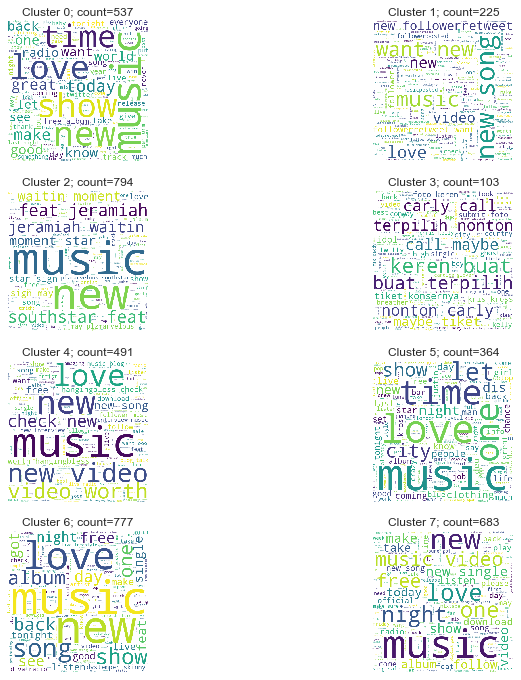

In [99]:
Ks = np.array([[0, 1], [2, 3],[4, 5], [6, 7]])

PlotClusterWordCloudArray(tokenised_matrix,cluster_d2v_cloud,Ks)

## Identifying topics in each cluster using the most frequent words

In [100]:
df_d2v_kmeans = df_preprocessed_user.copy()
df_d2v_kmeans["Cluster (d2v)"] = np.nan
for i in range(0, len(cluster_d2v_cloud)):
    df_d2v_kmeans["Cluster (d2v)"].iloc[i] = cluster_d2v_cloud[i]
df_d2v_kmeans

/Users/ShinnoOh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Tweet ID,Tweet Tokenised,User,Cluster (d2v)
0,1770013181,"[check, single, one, time, myspace, spread, word, thanks]",27260086,6.0
1,2094549639,"[chillin, myspace, music, check, live]",27260086,4.0
2,2196468811,"[single, one, time, hit, itunes, july, spread, word, request, local, radio, station, come, visit]",27260086,5.0
3,2430779345,"[columbus, red, white, boom, fri, come, full, support, five, best, wnci, justin, bieber, poster, get, picked, meet, greet]",27260086,3.0
4,2509156842,"[one, time, itunes, right, buy, time, let, make, lol, amazing, small, town, thank, much]",27260086,0.0
...,...,...,...,...
3969,330399658822213632,"[graphic, web, design, faculty, part, time, adjunct]",237507695,6.0
3970,330399746403479552,"[pleasse, help, trend, live]",406180496,4.0
3971,330399818092539905,"[time, exit, bank, weigh, prospect, stake, sale, sale, horizon, attention]",611654080,0.0
3972,330399904902021120,"[like, prayer, club, version, true, music, radio]",475702929,6.0


In [101]:
df_d2v_kmeans =  df_d2v_kmeans.merge(df[["Tweet ID", "Tweet"]], how='left', on="Tweet ID")
df_d2v_kmeans = df_d2v_kmeans.drop(labels="Tweet Tokenised", axis=1)
df_d2v_kmeans = df_d2v_kmeans[["Tweet ID", "Tweet", "User", "Cluster (d2v)"]]

In [102]:
cluster_token_1 = []
cluster_token_2 = []
cluster_token_3 = []
cluster_token_4 = []
cluster_token_5 = []
cluster_token_6 = []
cluster_token_7 = []
cluster_token_8 = []
for i, cluster in enumerate(cluster_d2v_cloud):
    if cluster == 0:
        cluster_token_1.append(tokenised_matrix[i])
    elif cluster == 1:
        cluster_token_2.append(tokenised_matrix[i])
    elif cluster == 2:
        cluster_token_3.append(tokenised_matrix[i])
    elif cluster == 3:
        cluster_token_4.append(tokenised_matrix[i])
    elif cluster == 4:
        cluster_token_5.append(tokenised_matrix[i])
    elif cluster == 5:
        cluster_token_6.append(tokenised_matrix[i])
    elif cluster == 6:
        cluster_token_7.append(tokenised_matrix[i])
    elif cluster == 7:
        cluster_token_8.append(tokenised_matrix[i])

In [103]:
import itertools
cluster_token_1_new = list(itertools.chain.from_iterable(cluster_token_1))
cluster_token_2_new = list(itertools.chain.from_iterable(cluster_token_2))
cluster_token_3_new = list(itertools.chain.from_iterable(cluster_token_3))
cluster_token_4_new = list(itertools.chain.from_iterable(cluster_token_4))
cluster_token_5_new = list(itertools.chain.from_iterable(cluster_token_5))
cluster_token_6_new = list(itertools.chain.from_iterable(cluster_token_6))
cluster_token_7_new = list(itertools.chain.from_iterable(cluster_token_7))
cluster_token_8_new = list(itertools.chain.from_iterable(cluster_token_8))

In [104]:
from collections import Counter
dic1 = {}
dic2 = {}
dic3 = {}
dic4 = {}
dic5 = {}
dic6 = {}
dic7 = {}
dic8 = {}

dic1 = Counter(cluster_token_1_new)
dic2 = Counter(cluster_token_2_new)
dic3 = Counter(cluster_token_3_new)
dic4 = Counter(cluster_token_4_new)
dic5 = Counter(cluster_token_5_new)
dic6 = Counter(cluster_token_6_new)
dic7 = Counter(cluster_token_7_new)
dic8 = Counter(cluster_token_8_new)

In [105]:
#display the most frequent words in each cluster
print("Cluster 1")
print(dic1.most_common(10))
print("Cluster 2")
print(dic2.most_common(10))
print("Cluster 3")
print(dic3.most_common(10))
print("Cluster 4")
print(dic4.most_common(10))
print("Cluster 5")
print(dic5.most_common(10))
print("Cluster 6")
print(dic6.most_common(10))
print("Cluster 7")
print(dic7.most_common(10))
print("Cluster 8")
print(dic8.most_common(10))

Cluster 1
[('music', 43), ('love', 41), ('today', 29), ('time', 28), ('get', 26), ('show', 25), ('new', 22), ('make', 20), ('may', 19), ('great', 18)]
Cluster 2
[('new', 136), ('song', 70), ('posted', 57), ('music', 51), ('follower', 45), ('want', 42), ('retweet', 37), ('love', 29), ('video', 18), ('check', 13)]
Cluster 3
[('music', 81), ('new', 70), ('may', 68), ('love', 54), ('feat', 53), ('get', 52), ('star', 51), ('moment', 49), ('sign', 49), ('show', 46)]
Cluster 4
[('call', 10), ('chris', 9), ('maybe', 9), ('kelly', 8), ('udah', 8), ('submit', 8), ('keren', 8), ('buat', 8), ('terpilih', 8), ('nonton', 8)]
Cluster 5
[('new', 168), ('music', 110), ('check', 71), ('video', 57), ('love', 49), ('song', 44), ('download', 30), ('worth', 30), ('hanging', 30), ('bless', 30)]
Cluster 6
[('music', 40), ('love', 22), ('one', 18), ('time', 16), ('night', 16), ('would', 15), ('let', 14), ('get', 14), ('show', 13), ('city', 12)]
Cluster 7
[('music', 82), ('new', 81), ('love', 62), ('get', 44), 

The above list shows top-frequent keywords in each cluster. <br>
<br>
For example, for cluster 3, there are keywords one and time. They don’t make much sense on their own, but if you search tweets with those keywords, you will see people are talking about justin Bieber’s song called One time. But it is difficult to find it our from individual words.<br>
<br>
For cluster 4, there are some spammy looking keywords like follower, and and retweets, but there are other keywords like check video, which seem to have nothing to do with the spammy words. <br>
<br>
In summary, it is not easy to interpret the true topics from top keywords because those words on their own do not have much meaning, also, many clusters share the same keywords.<br>
There is definitely a need for a better solution to find cluster topics for doc2vec method.<br>
